In [19]:
import pandas as pd
import numpy as np
import pyedflib
import os
import shutil
import glob
import datetime
from matplotlib import pyplot as plt

In [23]:
# Read raw PPG files

mdf = pd.read_csv(r'resteaze_train\00000175-resteaze-sync.csv', sep=',')
mdf.head()

,Unnamed: 0,counter,unixTimes,accelerometerX,accelerometerY,accelerometerZ,capacitorsA,capacitorsB,capacitorsC,gyroscopeX,...,Leg Movement,Hypopnea,Arousal,RERA,Relative Desaturation,Obstructive Apnea,Central Apnea,Leg Movement (L),Leg Movement (R),shifted_unixTimes
0,187659,187686,1.643780e+12,-118.0,286.0,-4224.0,0.0,NaN,NaN,109.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12
1,187660,187691,1.643780e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.643780e+12
2,187661,187687,1.643780e+12,-122.0,281.0,-4214.0,0.0,NaN,NaN,77.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12
3,187662,187692,1.643780e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.643780e+12
4,187663,187688,1.643780e+12,-133.0,279.0,-4212.0,0.0,NaN,NaN,82.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12


In [24]:
df = mdf[['ledGreen', 'sleep_stage', 'sleep_state']].dropna()
# df['sleep_state'] = df['sleep_state'].mask(lambda col: col == -1, 6)

df = df[df.sleep_state != -1]

# Applying the condition
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)
df.head()

,ledGreen,sleep_stage,sleep_state
12097,3267.0,WK,0
12099,3266.0,WK,0
12101,3268.0,WK,0
12103,3265.0,WK,0
12106,3265.0,WK,0


In [25]:
df['sleep_stage'].value_counts(), df['sleep_state'].value_counts()

(N2     168324
 WK     136580
 N3     110464
 REM     61198
 N1      35079
 Name: sleep_stage, dtype: int64,
 1    375065
 0    136580
 Name: sleep_state, dtype: int64)

#### Apply band pass filter to the signal

In [70]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

# apply bandpass filter

fs = 25
lowcut = 0.35
highcut = 5.0

pro_ppg = butter_bandpass_filter(df['ledGreen'], lowcut, highcut, fs, order=5)

In [71]:
from scipy import signal


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


# apply highpass filter

fs = 25
highcut = 5.0

cut_ppg = butter_highpass_filter(df['ledGreen'], highcut, fs, order=5)

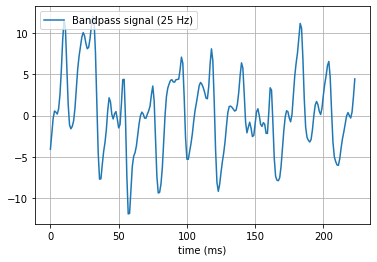

In [72]:
plt.plot(pro_ppg[800:1024], label='Bandpass signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

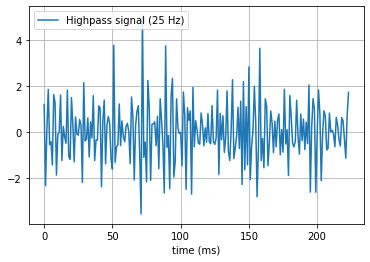

In [73]:
plt.plot(cut_ppg[800:1024], label='Highpass signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [70]:
pro_ppg.shape[0] % 750

145

In [71]:
ppg_signals = pro_ppg[:-(pro_ppg.shape[0] % 750)].reshape(-1, 750)

In [72]:
ppg_signals.shape

(682, 750)

In [73]:
timestamp = mdf['unixTimes'][0]

datetime.datetime.fromtimestamp(timestamp / 1000)

datetime.datetime(2022, 2, 2, 0, 33, 20)

### Visualize the predictions

In [1]:
# python predict.py --config_file config/resteaze.py --model_dir out_resteaze/train --output_dir out_resteaze/predict --log_file out_resteaze/predict.log --use-best

In [27]:
from numpy import load
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = load(r'../out_resteaze/predict/pred_00011978-resteaze-sync.npz')

preds = pd.DataFrame(data=zip(data['y_true'],data['y_pred']),columns=['True','Preds'])

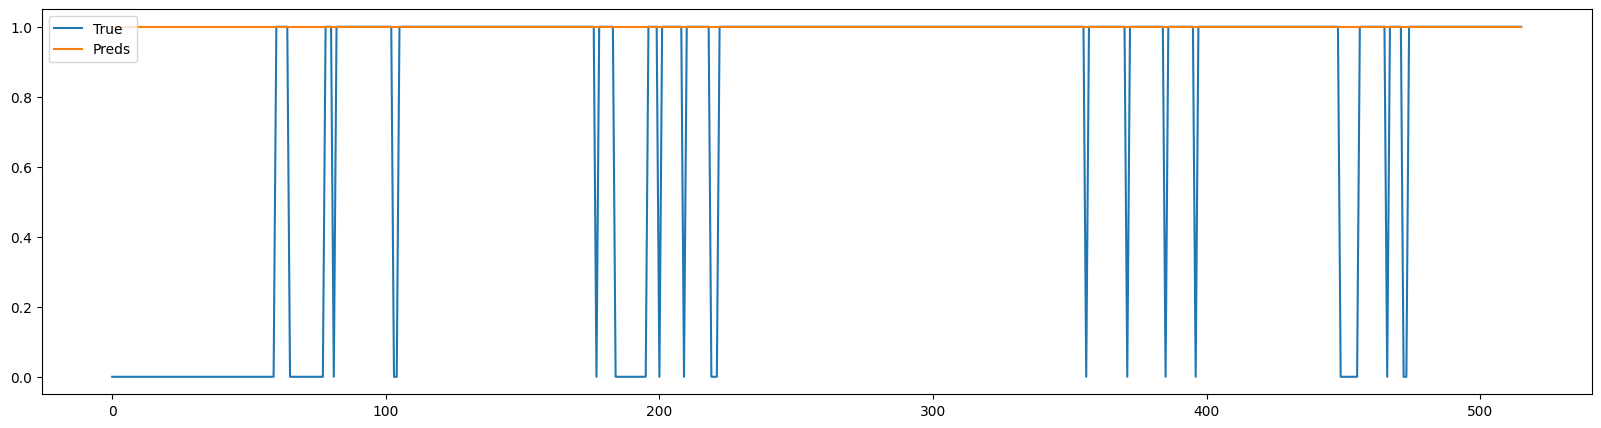

In [28]:
# figure size
plt.figure(figsize=(20,5))

plt.plot(preds['True'], label='True')
plt.plot(preds['Preds'], label='Preds')
plt.legend(loc='upper left')

plt.show();

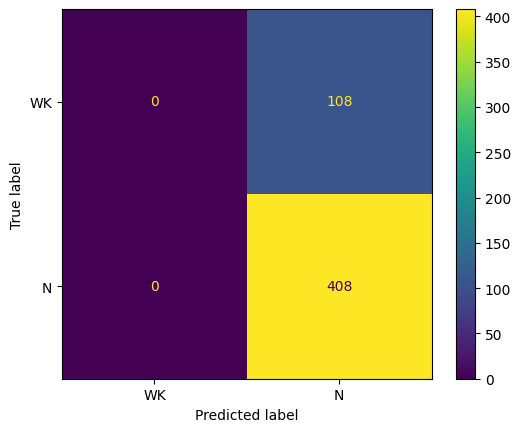

In [29]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(preds['True'], preds['Preds'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['WK', 'N'] )
cm_display.plot();



#### Cohen's Kappa score

In [31]:
from sklearn.metrics import cohen_kappa_score

cohen_score = cohen_kappa_score(preds['True'].tolist(),preds['Preds'].tolist())
cohen_score

0.0

## Test gpu usage

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPU


In [3]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1

